In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Swifter does not come pre-installed on Colab
# Swifter helps us to speed up Pandas apply methods
!pip3 install swifter
!pip3 install pandas_profiling
!pip3 install pycaret[full]

     |████████████████████████████████| 296 kB 15.1 MB/s 
     |████████████████████████████████| 123 kB 56.3 MB/s 
  Attempting uninstall: psutil
    Found existing installation: psutil 5.4.8
    Uninstalling psutil-5.4.8:
      Successfully uninstalled psutil-5.4.8


     |████████████████████████████████| 266 kB 14.7 MB/s 
     |████████████████████████████████| 2.0 MB 41.6 MB/s 
     |████████████████████████████████| 271 kB 74.4 MB/s 
     |████████████████████████████████| 111 kB 49.0 MB/s 
     |████████████████████████████████| 261 kB 46.8 MB/s 
     |████████████████████████████████| 56 kB 5.2 MB/s 
     |████████████████████████████████| 167 kB 61.2 MB/s 
     |████████████████████████████████| 80 kB 9.7 MB/s 
     |████████████████████████████████| 1.3 MB 42.6 MB/s 
     |████████████████████████████████| 14.6 MB 61.6 MB/s 
     |████████████████████████████████| 6.8 MB 33.0 MB/s 
     |████████████████████████████████| 1.7 MB 59.8 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 67.4 MB 57 kB/s 
     |████████████████████████████████| 131 kB 68.5 MB/s 
     |█████████████████

In [ ]:
import os
import swifter
import pandas as pd
import numpy as np
from pathlib import Path

## RFM Segmentation

Load the dataset online_retail.csv and use clustering techniques to segment the customers based on RFM (recency, frequency, monetary value).

> Recency — How recently did the customer purchase?

> Frequency — How often do they purchase?

> Monetary Value — How much do they spend?

Customer segmentation will aid the precision marketing efforts of the company.

The dataset is a transnational dataset containing all the retail transactions that occured between 01/12/2010 and 09/12/2011 for a UK-based pure online retail. 
The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.

In [ ]:
# Load the dataset
data_path = Path('/content/drive/My Drive/pcml_data/6USML')

filename = 'online_retail.csv'

df = pd.read_csv(
    data_path / filename,
    encoding='ISO-8859-1',
    header=0
)

#### Dataset Inspection

Descriptive statistics

In [ ]:
from pandas_profiling import ProfileReport

# Create a profile report
df.profile_report(minimal=True)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Next, we are going to engineer retail features that can help us segment customers according to relevant business objectives - (1) market share (revenue), (2) profit margin.

Retail transaction features that directly influence the above objectives:

> Recency (R)
>> Number of days since last purchase (measures customer repeat frequency, a measure of product demand, customer loyalty)
>
> Frequency (F)
>> Number of transactions
>
> Monetary (M)
>> Total revenue contributed

#### Step 1: Compute Recency

In [ ]:
import swifter
df['InvoiceDate'] = df.InvoiceDate.swifter.apply(pd.to_datetime)

In [ ]:
# Find the last date of purchase for each customer

# Since the dataset might not be recent, thus we benchmark
# it against the last date of purchase of the dataset

# Linear models will suffer from a truncation effect if
# there is a long period of break between the last record
# of the dataset and now. Although standardization can reduce 
# it, there is no reason to risk it.

df['recency'] = max(df.InvoiceDate) - df.InvoiceDate

In [ ]:
df.sort_values('recency', ascending=True)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,recency
394696,570876,23503,PLAYING CARDS KEEP CALM & CARRY ON,4,2011-12-10 17:19:00,1.25,16085.0,United Kingdom,0 days 00:00:00
394678,570876,46000S,POLYESTER FILLER PAD 40x40cm,1,2011-12-10 17:19:00,1.45,16085.0,United Kingdom,0 days 00:00:00
394679,570876,46000M,POLYESTER FILLER PAD 45x45cm,1,2011-12-10 17:19:00,1.55,16085.0,United Kingdom,0 days 00:00:00
394680,570876,23394,POSTE FRANCE CUSHION COVER,1,2011-12-10 17:19:00,3.75,16085.0,United Kingdom,0 days 00:00:00
394681,570876,23396,LE JARDIN BOTANIQUE CUSHION COVER,1,2011-12-10 17:19:00,3.75,16085.0,United Kingdom,0 days 00:00:00
...,...,...,...,...,...,...,...,...,...
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom,697 days 08:53:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom,697 days 08:53:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-01-12 08:26:00,2.75,17850.0,United Kingdom,697 days 08:53:00
1,536365,71053,WHITE METAL LANTERN,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom,697 days 08:53:00


In [ ]:
# Extract the latest transaction on a customer basis
rfm_r = df.groupby('CustomerID')['recency'].min()
rfm_r

CustomerID
12346.0   326 days 07:18:00
12347.0    40 days 04:54:00
12348.0    76 days 04:06:00
12349.0    19 days 07:28:00
12350.0   311 days 01:18:00
                 ...       
18280.0   160 days 07:27:00
18281.0     4 days 06:26:00
18282.0   216 days 03:44:00
18283.0    10 days 04:20:00
18287.0     0 days 06:56:00
Name: recency, Length: 4335, dtype: timedelta64[ns]

In [ ]:
# Reset index and set CustomerID as index
# Setting CustomerID as index will reduce merging
# errors if we are confused between append, concat, merge
rfm_r = rfm_r.reset_index().set_index('CustomerID')
rfm_r

,recency
CustomerID,
12346.0,326 days 07:18:00
12347.0,40 days 04:54:00
12348.0,76 days 04:06:00
12349.0,19 days 07:28:00
12350.0,311 days 01:18:00
...,...
18280.0,160 days 07:27:00
18281.0,4 days 06:26:00
18282.0,216 days 03:44:00


In [ ]:
# For modeling purposes, we need to convert a datetime
# object (in this case, a timedelta object) to an integer/float
# For this use-case, number of days is the most appropriate
rfm_r['recency'] = rfm_r.recency.dt.days
rfm_r

,recency
CustomerID,
12346.0,326
12347.0,40
12348.0,76
12349.0,19
12350.0,311
...,...
18280.0,160
18281.0,4
18282.0,216


#### Step 2: Compute Frequency

In [ ]:
# This metric is simply a count of the number of
# unique items per transaction that a customer makes

# Each unique item in the given dataset is
# indicated under the respective invoice number.
# E.g. Invoice number 536365 includes the first
# 5 stockcodes.

# Why unique items per transaction and not 
# number of items purchased?
# Due to the nature of the items purchased, if we
# use number of items purchased, we will end up
# giving more weights to customers that purchase
# small items at high quantity.

# Why unique items per transactions and not number of
# unique invoices? Some customers may purchase a large
# number of items per invoice while others split up
# their purchases. The difference is likely attributed
# to customer idiosyncracies or the presence of discounts
# or unique circumstances. Since there are many confounding
# possibilities, we balance these considerations and use
# unique items per transaction.

rfm_f = df.groupby('CustomerID')['InvoiceNo'].count()
rfm_f

CustomerID
12346.0      1
12347.0    182
12348.0     27
12349.0     72
12350.0     16
          ... 
18280.0     10
18281.0      7
18282.0     12
18283.0    719
18287.0     70
Name: InvoiceNo, Length: 4335, dtype: int64

In [ ]:
# Reset index and set CustomerID as index
# Setting CustomerID as index will reduce merging
# errors if we are confused between append, concat, merge
rfm_f = rfm_f.reset_index().set_index('CustomerID')
rfm_f.rename({'InvoiceNo': 'frequency'}, axis=1, inplace=True)
rfm_f

,frequency
CustomerID,
12346.0,1
12347.0,182
12348.0,27
12349.0,72
12350.0,16
...,...
18280.0,10
18281.0,7
18282.0,12


#### Compute Monetary

In [ ]:
# Monetary metric is simply total revenue generated
# by each customer

# First, we compute the total revenue generated per
# line item
df['monetary'] = df.Quantity * df.UnitPrice

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
# Next, we group them by customers
rfm_m = df.groupby('CustomerID')['monetary'].sum()
rfm_m

CustomerID
12346.0    77183.60
12347.0     4310.00
12348.0     1437.24
12349.0     1457.55
12350.0      294.40
             ...   
18280.0      180.60
18281.0       80.82
18282.0      178.05
18283.0     2039.58
18287.0     1837.28
Name: monetary, Length: 4335, dtype: float64

In [ ]:
# Reset index and set CustomerID as index
# Setting CustomerID as index will reduce merging
# errors if we are confused between append, concat, merge
rfm_m = rfm_m.reset_index().set_index('CustomerID')
rfm_m

,monetary
CustomerID,
12346.0,77183.60
12347.0,4310.00
12348.0,1437.24
12349.0,1457.55
12350.0,294.40
...,...
18280.0,180.60
18281.0,80.82
18282.0,178.05


#### Merging

Here, we pool all the dataframes together so that we have the RFM metrics per customer.

In [ ]:
# We use the concat function so that we can
# merge all 3 dataframes in 1 pass.

# Remember to specify axis=1 so that the datasets
# are joined by columns, else they will be stacked (append)

# Lastly, since we require all rows to have values, we use
# inner join which will drop any customer id that have missing
# values for either R, F, or M.

rfm = pd.concat([rfm_r, rfm_f, rfm_m], axis=1, join='inner')
rfm

,recency,frequency,monetary
CustomerID,,,
12346.0,326,1,77183.60
12347.0,40,182,4310.00
12348.0,76,27,1437.24
12349.0,19,72,1457.55
12350.0,311,16,294.40
...,...,...,...
18280.0,160,10,180.60
18281.0,4,7,80.82
18282.0,216,12,178.05


In [ ]:
# Save the model
rfm.to_csv(data_path / 'rfm.csv')

In [ ]:
# If we take a break from the project, we
# can load the rfm file here and continue
rfm = pd.read_csv(data_path / 'rfm.csv')

### Inspecting the dataset

In [ ]:
# Check distribution of RFM
rfm.profile_report(minimal=True)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### Data Modeling

Let's use clustering techniques to segment the customers.

In [ ]:
from pycaret.clustering import *

In [ ]:
rfm_study = setup(
    data=rfm, 
    normalize=True, 
    silent=True
    )

,Description,Value
0,session_id,539
1,Original Data,"(4331, 3)"
2,Missing Values,False
3,Numeric Features,3
4,Categorical Features,0
5,Ordinal Features,False
6,High Cardinality Features,False
7,High Cardinality Method,None
8,Transformed Data,"(4331, 3)"
9,CPU Jobs,-1


In [ ]:
# What are the available models?
models()

,Name,Reference
ID,,
kmeans,K-Means Clustering,sklearn.cluster._kmeans.KMeans
ap,Affinity Propagation,sklearn.cluster._affinity_propagation.Affinity...
meanshift,Mean Shift Clustering,sklearn.cluster._mean_shift.MeanShift
sc,Spectral Clustering,sklearn.cluster._spectral.SpectralClustering
hclust,Agglomerative Clustering,sklearn.cluster._agglomerative.AgglomerativeCl...
dbscan,Density-Based Spatial Clustering,sklearn.cluster._dbscan.DBSCAN
optics,OPTICS Clustering,sklearn.cluster._optics.OPTICS
birch,Birch Clustering,sklearn.cluster._birch.Birch
kmodes,K-Modes Clustering,kmodes.kmodes.KModes


In [ ]:
kmeans = create_model('kmeans', num_clusters=3)

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.5162,2314.883,0.7031,0,0,0


In [ ]:
# Elbow Plot
plot_model(kmeans, plot='elbow')

In [ ]:
create_model('kmeans', num_clusters=3)

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.5162,2314.883,0.7031,0,0,0


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=-1, precompute_distances='deprecated',
       random_state=539, tol=0.0001, verbose=0)

In [ ]:
create_model('kmeans', num_clusters=4)

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.5265,2546.946,0.6176,0,0,0


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=-1, precompute_distances='deprecated',
       random_state=539, tol=0.0001, verbose=0)

In [ ]:
create_model('kmeans', num_clusters=5)

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.5474,2932.8484,0.6801,0,0,0


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=-1, precompute_distances='deprecated',
       random_state=539, tol=0.0001, verbose=0)

In [ ]:
create_model('kmeans', num_clusters=6)

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.5459,3104.0271,0.6392,0,0,0


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=6, n_init=10, n_jobs=-1, precompute_distances='deprecated',
       random_state=539, tol=0.0001, verbose=0)

In [ ]:
create_model('kmeans', num_clusters=7)

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.543,3228.5754,0.6574,0,0,0


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=7, n_init=10, n_jobs=-1, precompute_distances='deprecated',
       random_state=539, tol=0.0001, verbose=0)

In [ ]:
# Final model - cluster size of 5
kmeans = create_model('kmeans', num_clusters=5)

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.5474,2932.8484,0.6801,0,0,0


In [ ]:
rfm_cluster = assign_model(kmeans)
rfm_cluster

,recency,frequency,monetary,Cluster
0,326,1,0.00,Cluster 2
1,40,182,4310.00,Cluster 0
2,76,31,1437.24,Cluster 0
3,19,73,1457.55,Cluster 0
4,311,17,294.40,Cluster 2
...,...,...,...,...
4326,160,10,180.60,Cluster 2
4327,4,7,80.82,Cluster 0
4328,216,12,176.60,Cluster 2
4329,10,721,2039.58,Cluster 4


# More analysis

In [ ]:
plot_model(kmeans, plot='distribution')

In [ ]:
plot_model(kmeans, plot='tsne')

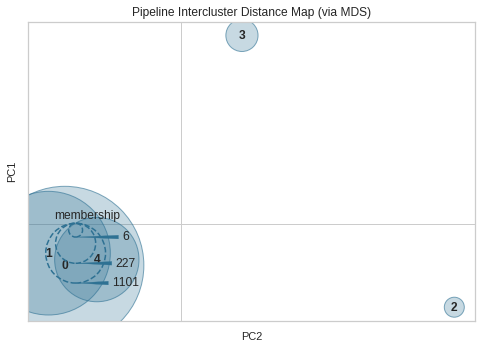

In [ ]:
plot_model(kmeans, plot='distance')

#### Inspecting the results

Here, we use visualizations to derive insights from the clustering results.

In [ ]:
import seaborn as sns

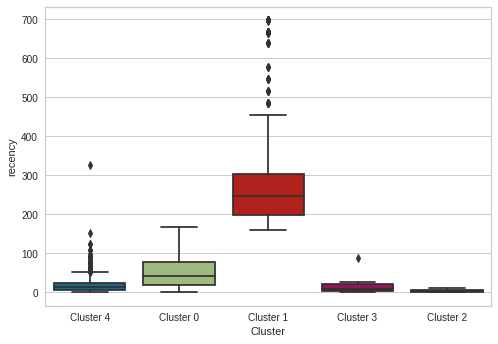

In [ ]:
# Clusters vs Recency
sns.boxplot('Cluster', 'recency', data=rfm_cluster)

Are the clusters well separated in terms of recency of purchase?

>Cluster __ - Last purchase most recent
>
>Cluster __ - Last purchase most distant


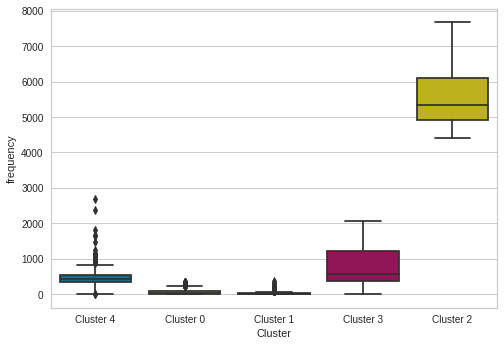

In [ ]:
# Clusters vs Frequency
sns.boxplot('Cluster', 'frequency', data=rfm_cluster)

Are the clusters well separated in terms of frequency of purchase?

>Cluster __ - Highest frequency
>
>Cluster __ - Lowest frequency

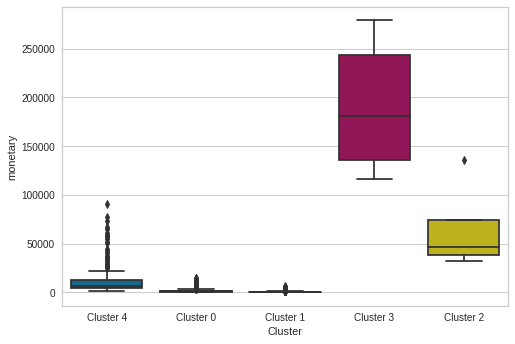

In [ ]:
# Clusters vs Monetary Value
sns.boxplot('Cluster', 'monetary', data=rfm_cluster)

Are the clusters well separated in terms of monetary value?

>Cluster __ - Contributes the highest revenue
>
>Cluster __ - Lowest revenue

How would you tag the persona for the various clusters? What strategies will you use to target them?

Class Exercise: Please perform the same process in PyCaret but use
1. hclust - hierarchical clustering
2. ap - affinity propagation

In [ ]:
# What are the available models?
models()

,Name,Reference
ID,,
kmeans,K-Means Clustering,sklearn.cluster._kmeans.KMeans
ap,Affinity Propagation,sklearn.cluster._affinity_propagation.Affinity...
meanshift,Mean Shift Clustering,sklearn.cluster._mean_shift.MeanShift
sc,Spectral Clustering,sklearn.cluster._spectral.SpectralClustering
hclust,Agglomerative Clustering,sklearn.cluster._agglomerative.AgglomerativeCl...
dbscan,Density-Based Spatial Clustering,sklearn.cluster._dbscan.DBSCAN
optics,OPTICS Clustering,sklearn.cluster._optics.OPTICS
birch,Birch Clustering,sklearn.cluster._birch.Birch
kmodes,K-Modes Clustering,kmodes.kmodes.KModes


In [ ]:
hclust = create_model('hclust')

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.4689,2234.7877,0.6574,0,0,0


    Silhou    Calinski     Davies
    0.5474	2932.8484	0.6801

In [ ]:
plot_model(hclust, plot='distribution')